GitHub: https://github.com/janderss0n/titanic_ml_example

Data from: https://www.kaggle.com/c/titanic/overview

# Predict survival on Titanic
Supervised learning, we have labeled dataset we can train a model on.
Our target, survived or not (0,1), is categorical so we can use a classification model.

In [1]:
import pandas as pd
import numpy as np

Load the training data

In [2]:
original_data = pd.read_csv('titanic_data/train.csv')
original_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Survived is our target.
Let's use Pclass, Sex, Age, Cabin, Embarked.

In [3]:
target = 'Survived'
interesting_columns = ['Pclass', 'Sex', 'Age', 'Cabin', 'Embarked']
data = original_data.loc[:, interesting_columns + [target]]

# Exploratory data analysis (EDA)

In [13]:
import seaborn as sns
sns.set(context='notebook', style='whitegrid', 
        palette='pastel', font='sans-serif', 
        font_scale=2, color_codes=True, rc=None)

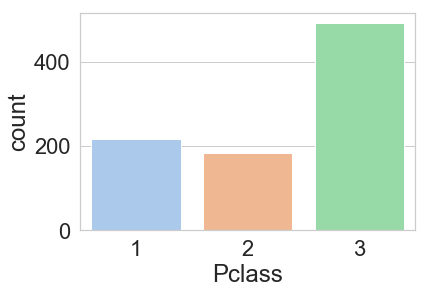

In [14]:
sns.countplot('Pclass', data=data)

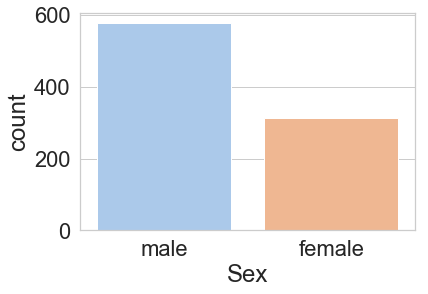

In [15]:
sns.countplot('Sex', data=data)

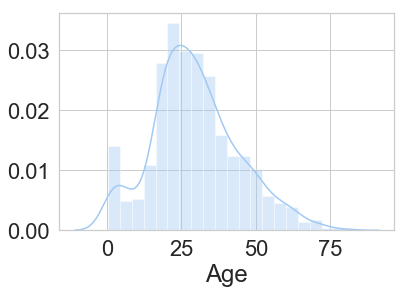

In [16]:
sns.distplot(data.loc[data['Age'].notnull(),'Age'])

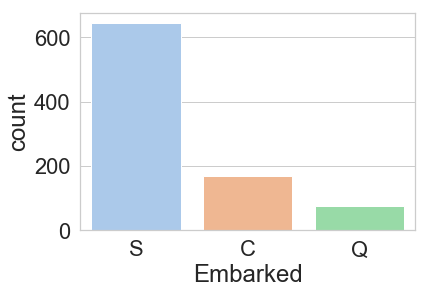

In [17]:
sns.countplot('Embarked', data=data)

We can combine two columns

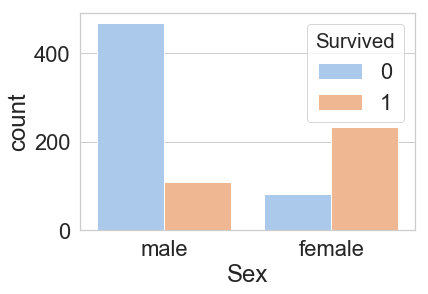

In [18]:
sns.countplot('Sex', hue='Survived', data=data)

Important to look at the balance between each class in the target.
If it is imbalanced between classes you will have to fix that.

If 0 would be 95% and 1 5%, then a trained model always guessing 0 would have 95% acc.

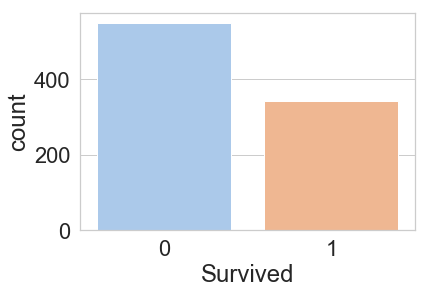

In [19]:
sns.countplot(target, data=data)

## Data Preprocessing

Choose equal number of examples from each target class. Then shuffle dataset.

In [20]:
min_target_class_samples = data[target].value_counts().min()
non_survival_ex = data.loc[data[target]==0,:]
proc_data = non_survival_ex.sample(n=min_target_class_samples, 
                                           replace=False, random_state=42)
proc_data = proc_data.append(data.loc[data[target]==1,:])
proc_data = proc_data.sample(frac=1).reset_index(drop=True)
print(proc_data[target].value_counts())

1    342
0    342
Name: Survived, dtype: int64


Some alg. can't handle string values/categorical columns. These need to be processed.

In [21]:
# Replace value with 1 and nan with 0 in Cabin column.
proc_data.loc[proc_data['Cabin'].notnull(), 'Cabin'] = 1
proc_data.loc[proc_data['Cabin'].isnull(), 'Cabin'] = 0

In [22]:
# Split Sex and Embarked categories to separate columns
new_embarked = pd.get_dummies(proc_data['Embarked'], prefix='Embarked')
new_sex = pd.get_dummies(proc_data['Sex'])
proc_data = pd.concat([proc_data, new_embarked, new_sex], axis=1)
proc_data.head()

,Pclass,Sex,Age,Cabin,Embarked,Survived,Embarked_C,Embarked_Q,Embarked_S,female,male
0,3,male,9.0,0,S,0,0,0,1,0,1
1,3,male,24.0,0,S,0,0,0,1,0,1
2,3,male,33.0,0,S,0,0,0,1,0,1
3,3,female,23.0,0,S,0,0,0,1,1,0
4,1,male,47.0,1,S,0,0,0,1,0,1


Check if we have any NaN values

In [23]:
proc_data.isnull().sum()

Pclass          0
Sex             0
Age           129
Cabin           0
Embarked        2
Survived        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
female          0
male            0
dtype: int64

Remove rows with NaN from training data or replace with a clever value.

In [24]:
proc_data.describe()

,Pclass,Age,Cabin,Survived,Embarked_C,Embarked_Q,Embarked_S,female,male
count,684.000000,555.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000
mean,2.241228,29.923730,0.251462,0.500000,0.211988,0.083333,0.701754,0.418129,0.581871
std,0.853206,14.585599,0.434171,0.500366,0.409016,0.276588,0.457823,0.493613,0.493613
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,29.000000,0.000000,0.500000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,3.000000,39.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,3.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
proc_data.Age.median()

29.0

In [26]:
# Replace nan with median age
median_age = proc_data.Age.median()
proc_data.loc[proc_data.Age.isnull(), 'Age'] = median_age

How does it look now?

In [27]:
proc_data.isnull().sum()

Pclass        0
Sex           0
Age           0
Cabin         0
Embarked      2
Survived      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
female        0
male          0
dtype: int64

In [28]:
proc_data.describe()

,Pclass,Age,Cabin,Survived,Embarked_C,Embarked_Q,Embarked_S,female,male
count,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000
mean,2.241228,29.749518,0.251462,0.500000,0.211988,0.083333,0.701754,0.418129,0.581871
std,0.853206,13.141148,0.434171,0.500366,0.409016,0.276588,0.457823,0.493613,0.493613
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,29.000000,0.000000,0.500000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,3.000000,36.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,3.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Train a Random Forest Classifier model

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

Split the data into train and test. OBS! You should always have a 3:rd dataset saved for a final, final testing to reduce bias in your score.

In [30]:
X = proc_data.drop(columns=[target]).select_dtypes(include='number')
y = proc_data[target]
print(X.head())
print(y.head())

   Pclass   Age  Cabin  Embarked_C  Embarked_Q  Embarked_S  female  male
0       3   9.0      0           0           0           1       0     1
1       3  24.0      0           0           0           1       0     1
2       3  33.0      0           0           0           1       0     1
3       3  23.0      0           0           0           1       1     0
4       1  47.0      1           0           0           1       0     1
0    0
1    0
2    0
3    0
4    0
Name: Survived, dtype: int64


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [32]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Make prediction on  test set

In [33]:
y_pred = model.predict(X_test)
print(X_test[0:5])
y_pred[0:5]

     Pclass   Age  Cabin  Embarked_C  Embarked_Q  Embarked_S  female  male
497       3  21.0      0           0           0           1       0     1
231       3  29.0      0           0           0           1       0     1
212       3  29.0      0           1           0           0       0     1
118       2  17.0      0           0           0           1       1     0
670       3  48.0      0           0           0           1       0     1


array([0, 0, 0, 1, 0])

# Plot ROC curve for evaluation

In [34]:
# Predict probabilities
probs = model.predict_proba(X_test)
probs = probs[:, 1] # keep probabilities for the positive outcome only

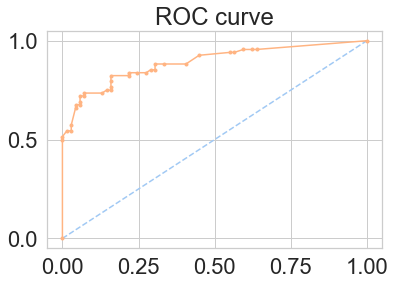

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.plot(fpr, tpr, marker='.') # plot the roc curve for the model
plt.title('ROC curve')
plt.show()

# Get all of the trees in the model

In [36]:
#model.estimators_

In [37]:
import os
import six
import pydot
from sklearn import tree
from sklearn.tree import export_graphviz

estimator = model.estimators_[5]
dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in model.estimators_:
    export_graphviz(tree_in_forest,out_file='tree.dot',
    feature_names=X_train.columns,
    filled=True,
    rounded=True)
    (graph,) = pydot.graph_from_dot_file('tree.dot')
    name = 'tree' + str(i_tree)
    graph.write_png(name+  '.png')
    os.system('dot -Tpng tree.dot -o tree.png')
    i_tree +=1


<img src='tree.png'>

# Save the trained model to file
For later use in API

In [38]:
import pickle
pickle.dump(model, open('model_titanic_survival.pkl', 'wb'))